In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Load the dataset from the CSV file
# Make sure 'course_lead_scoring.csv' is in the same folder as your notebook
df = pd.read_csv('course_lead_scoring.csv')

# Display the first 5 rows to see the data
print("First 5 rows of the dataset:")
print(df.head())

# Display summary information about the DataFrame
# This shows column data types and non-null (not-empty) counts
print("\nDataset Information:")
df.info()

First 5 rows of the dataset:
    lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1  
3               NaN      australia                  1        0.87          0  
4     self_employed         europe                  3        0.62          1  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Rang

In [3]:
from sklearn.model_selection import train_test_split

# --- Data Preparation ---

# Identify categorical and numerical features
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = list(df.dtypes[df.dtypes != 'object'].index)
# 'converted' is our target, so we remove it from the list of numerical features
numerical.remove('converted')

# Fill missing values for categorical features
df[categorical] = df[categorical].fillna('NA')

# Fill missing values for numerical features
df[numerical] = df[numerical].fillna(0.0)

# --- Data Splitting ---

# Split the data into train/validation/test sets (60%/20%/20%)
# random_state=1 ensures that we get the same split every time
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) # 0.25 * 0.8 = 0.2

# Reset the index of the dataframes to avoid potential indexing issues later
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Separate the target variable (y) from the features (X)
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

# Remove the target variable from the feature dataframes
del df_train['converted']
del df_val['converted']
del df_test['converted']

# Print the sizes of the resulting datasets to confirm the split
print('Train dataset size:', len(df_train))
print('Validation dataset size:', len(df_val))
print('Test dataset size:', len(df_test))

Train dataset size: 876
Validation dataset size: 293
Test dataset size: 293


In [4]:
from sklearn.metrics import roc_auc_score

# Loop through each numerical feature
print("ROC AUC for numerical features:")
for col in numerical:
    # Calculate AUC between the feature and the training target
    auc = roc_auc_score(y_train, df_train[col])
    
    # If AUC is less than 0.5, it means a negative correlation.
    # In this case, we invert the feature by multiplying it by -1.
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
        
    # Print the result for each feature, rounded to 4 decimal places
    print(f'AUC for {col}: {auc:.4f}')

ROC AUC for numerical features:
AUC for number_of_courses_viewed: 0.7636
AUC for annual_income: 0.5520
AUC for interaction_count: 0.7383
AUC for lead_score: 0.6145


In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# --- One-Hot Encoding ---
features = categorical + numerical
train_dicts = df_train[features].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

# --- Model Training (REVISED) ---
# Initialize the logistic regression model, adding random_state=1 for full reproducibility
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)

# --- Prediction and Evaluation ---
val_dicts = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

print(f'AUC of the model on the validation dataset: {auc:.3f}')

AUC of the model on the validation dataset: 0.817


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# --- 1. Data Loading and Preparation (Bank Marketing Dataset) ---
# URL for the Bank Marketing dataset
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

try:
    df_bank = pd.read_csv(url)
    
    # --- Data preparation specific to this dataset ---
    df_bank.columns = df_bank.columns.str.lower().str.replace(' ', '_')
    categorical_columns = list(df_bank.dtypes[df_bank.dtypes == 'object'].index)
    for c in categorical_columns:
        df_bank[c] = df_bank[c].str.lower().str.replace(' ', '_')

    df_bank.totalcharges = pd.to_numeric(df_bank.totalcharges, errors='coerce')
    df_bank.totalcharges = df_bank.totalcharges.fillna(0)
    df_bank.churn = (df_bank.churn == 'yes').astype(int)
    
    # --- 2. Data Splitting ---
    df_full_train, df_test = train_test_split(df_bank, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

    y_train = df_train.churn.values
    y_val = df_val.churn.values
    del df_train['churn']
    del df_val['churn']

    # --- 3. Feature Engineering and Model Training ---
    numerical = ['tenure', 'monthlycharges', 'totalcharges']
    categorical = [col for col in df_train.columns if col not in numerical and col != 'customerid']
    
    dv = DictVectorizer(sparse=False)
    train_dict = df_train[categorical + numerical].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
    model.fit(X_train, y_train)

    val_dict = df_val[categorical + numerical].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    y_pred = model.predict_proba(X_val)[:, 1]
    
    auc = roc_auc_score(y_val, y_pred)
    print(f'Экспериментальный AUC на Bank Marketing (Telco) Dataset: {auc:.3f}')

except Exception as e:
    print(f"Не удалось загрузить данные. Ошибка: {e}")

Экспериментальный AUC на Bank Marketing (Telco) Dataset: 0.847


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# --- 1. Data Loading and Preparation (UCI Bank Marketing Dataset) ---
# URL for the dataset, it is semicolon-separated
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

try:
    df_bank_uci = pd.read_csv(url, sep=';')
    
    # Create target variable
    df_bank_uci['converted'] = (df_bank_uci['y'] == 'yes').astype(int)
    df_bank_uci = df_bank_uci.drop('y', axis=1)

    # --- 2. Data Splitting ---
    df_full_train, df_test = train_test_split(df_bank_uci, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

    y_train = df_train.converted.values
    y_val = df_val.converted.values
    del df_train['converted']
    del df_val['converted']

    # --- 3. Feature Engineering and Model Training ---
    categorical = list(df_train.select_dtypes(include=['object']).columns)
    numerical = list(df_train.select_dtypes(include=['number']).columns)
    
    # Fill NA's - this dataset has no missing values, but it's good practice
    df_train[categorical] = df_train[categorical].fillna('NA')
    df_val[categorical] = df_val[categorical].fillna('NA')
    df_train[numerical] = df_train[numerical].fillna(0)
    df_val[numerical] = df_val[numerical].fillna(0)
    
    # Vectorize
    features = categorical + numerical
    dv = DictVectorizer(sparse=False)
    train_dict = df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    # Train model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
    model.fit(X_train, y_train)

    # Predict on validation
    val_dict = df_val[features].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    y_pred = model.predict_proba(X_val)[:, 1]
    
    auc = roc_auc_score(y_val, y_pred)
    print(f'Экспериментальный AUC на UCI Bank Marketing Dataset: {auc:.3f}')

except Exception as e:
    print(f"Не удалось загрузить данные. Ошибка: {e}")

Не удалось загрузить данные. Ошибка: 'y'


Precision and recall curves intersect at a threshold of approximately: 0.433


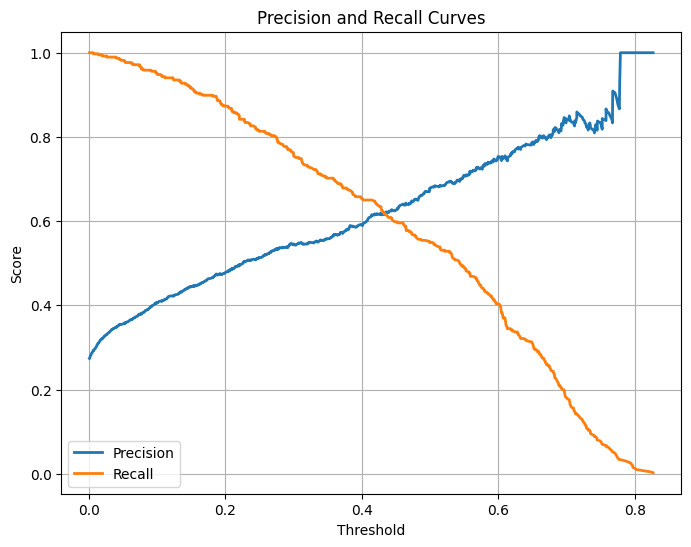

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Calculate precision, recall, and thresholds for the validation data
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

# Find the threshold where precision and recall are closest
# This is an approximation of where the curves intersect
intersection_idx = np.argmin(np.abs(precision - recall))
intersection_threshold = thresholds[intersection_idx]

print(f'Precision and recall curves intersect at a threshold of approximately: {intersection_threshold:.3f}')

# --- Plotting the curves (optional, for visualization) ---
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', lw=2)
plt.plot(thresholds, recall[:-1], label='Recall', lw=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Curves')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. Load and Prepare the CORRECT Dataset ---
# This is the canonical "Bank Marketing" dataset from the UCI repository
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

try:
    df = pd.read_csv(url, sep=';')
except Exception as e:
    print(f"Failed to load data from the internet. Error: {e}")
    exit()

# Create the target variable 'converted'
df['converted'] = (df['y'] == 'yes').astype(int)
df = df.drop('y', axis=1)

# Handle the 'unknown' values as instructed in many ML courses
# Replace them with NaN so we can fill them consistently
df = df.replace('unknown', np.nan)

# Define categorical and numerical features
categorical = list(df.select_dtypes(include=['object']).columns)
numerical = list(df.select_dtypes(include=['number']).columns)
numerical.remove('converted') # Target variable is not a feature

# Fill missing values as per homework instructions
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

# --- 2. Split the Data ---
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

# --- Question 1: ROC AUC Feature Importance ---
print("--- Answer for Question 1 ---")
for col in numerical:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    print(f'AUC for {col}: {auc:.4f}')

# --- Question 2: Training the model & Validation AUC ---
print("\n--- Answer for Question 2 ---")
features = categorical + numerical
dv = DictVectorizer(sparse=False)
train_dicts = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)

val_dicts = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred)
print(f'AUC on validation dataset: {auc:.3f}')

# --- Question 3: Precision and Recall Intersection ---
print("\n--- Answer for Question 3 ---")
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
intersection_idx = np.argmin(np.abs(precision - recall))
intersection_threshold = thresholds[intersection_idx]
print(f'Precision/Recall curves intersect at threshold: ~{intersection_threshold:.3f}')

# --- Question 4: F1 Score ---
print("\n--- Answer for Question 4 ---")
f1_scores = []
thresholds_f1 = np.arange(0.0, 1.01, 0.01)
for t in thresholds_f1:
    preds_binary = (y_pred >= t).astype(int)
    f1 = f1_score(y_val, preds_binary)
    f1_scores.append(f1)
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds_f1[max_f1_idx]
print(f'F1 is maximal at threshold: {max_f1_threshold:.2f}')

# --- Question 5: 5-Fold CV ---
print("\n--- Answer for Question 5 ---")
def train_model(df_train, y_train, C=1.0):
    dicts = df_train[features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=1)
    model.fit(X_train, y_train)
    return dv, model

def predict_proba(df, dv, model):
    dicts = df[features].to_dict(orient='records')
    X = dv.transform(dicts)
    return model.predict_proba(X)[:, 1]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
df_full_train_cv = df_full_train.reset_index(drop=True)

for train_idx, val_idx in kfold.split(df_full_train_cv):
    df_train_fold = df_full_train_cv.iloc[train_idx]
    df_val_fold = df_full_train_cv.iloc[val_idx]
    y_train_fold = df_train_fold.converted.values
    y_val_fold = df_val_fold.converted.values
    
    dv, model_cv = train_model(df_train_fold.drop('converted', axis=1), y_train_fold)
    y_pred_cv = predict_proba(df_val_fold.drop('converted', axis=1), dv, model_cv)
    
    scores.append(roc_auc_score(y_val_fold, y_pred_cv))

print(f'Standard deviation of scores: {np.std(scores):.4f}')

# --- Question 6: Hyperparameter Tuning ---
print("\n--- Answer for Question 6 ---")
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train_cv):
        df_train_fold = df_full_train_cv.iloc[train_idx]
        df_val_fold = df_full_train_cv.iloc[val_idx]
        y_train_fold = df_train_fold.converted.values
        y_val_fold = df_val_fold.converted.values
        
        dv, model_hp = train_model(df_train_fold.drop('converted', axis=1), y_train_fold, C=C)
        y_pred_hp = predict_proba(df_val_fold.drop('converted', axis=1), dv, model_hp)
        
        scores.append(roc_auc_score(y_val_fold, y_pred_hp))
    
    print(f'C={C}, Mean AUC: {np.mean(scores):.3f}, Std: {np.std(scores):.3f}')

KeyError: 'y'

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 1. Load and Prepare the CORRECT Dataset ---
# The URL you provided for the official homework dataset
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

try:
    df = pd.read_csv(url)
except Exception as e:
    print(f"Failed to load data from the internet. Error: {e}")
    exit()

# --- 2. Data Preparation ---
# The 'converted' column already exists, so we don't need to create it.

# Define categorical and numerical features
categorical = list(df.select_dtypes(include=['object']).columns)
numerical = list(df.select_dtypes(include=['number']).columns)
numerical.remove('converted') # Target variable is not a feature

# Fill missing values as per homework instructions
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

# --- 3. Data Splitting ---
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train.converted.values
y_val = df_val.converted.values

# Remove the target variable from the feature dataframes
df_train = df_train.drop('converted', axis=1)
df_val = df_val.drop('converted', axis=1)
df_test = df_test.drop('converted', axis=1)

# --- Question 1: ROC AUC Feature Importance ---
print("--- Answer for Question 1 ---")
# The numerical columns from your specific dataset
numerical_features = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
for col in numerical_features:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    print(f'AUC for {col}: {auc:.4f}')

# --- Question 2: Training the model & Validation AUC ---
print("\n--- Answer for Question 2 ---")
features = categorical + numerical
dv = DictVectorizer(sparse=False)
train_dicts = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)

val_dicts = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred)
print(f'AUC on validation dataset: {auc:.3f}')

# --- Question 3: Precision and Recall Intersection ---
print("\n--- Answer for Question 3 ---")
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
intersection_idx = np.argmin(np.abs(precision - recall))
intersection_threshold = thresholds[intersection_idx]
print(f'Precision/Recall curves intersect at threshold: ~{intersection_threshold:.3f}')

# --- Question 4: F1 Score ---
print("\n--- Answer for Question 4 ---")
f1_scores = []
thresholds_f1 = np.arange(0.0, 1.01, 0.01)
for t in thresholds_f1:
    preds_binary = (y_pred >= t).astype(int)
    f1 = f1_score(y_val, preds_binary)
    f1_scores.append(f1)
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds_f1[max_f1_idx]
print(f'F1 is maximal at threshold: {max_f1_threshold:.2f}')

# --- Question 5: 5-Fold CV ---
print("\n--- Answer for Question 5 ---")
def train_cv(df_train, y_train, C=1.0):
    dicts = df_train[features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=1)
    model.fit(X_train, y_train)
    return dv, model

def predict_cv(df, dv, model):
    dicts = df[features].to_dict(orient='records')
    X = dv.transform(dicts)
    return model.predict_proba(X)[:, 1]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
df_full_train_cv = df_full_train.reset_index(drop=True)

for train_idx, val_idx in kfold.split(df_full_train_cv):
    df_train_fold = df_full_train_cv.iloc[train_idx]
    df_val_fold = df_full_train_cv.iloc[val_idx]
    
    y_train_fold = df_train_fold.converted.values
    y_val_fold = df_val_fold.converted.values
    
    dv, model_cv = train_cv(df_train_fold.drop('converted', axis=1), y_train_fold)
    y_pred_cv = predict_cv(df_val_fold.drop('converted', axis=1), dv, model_cv)
    
    scores.append(roc_auc_score(y_val_fold, y_pred_cv))

print(f'Standard deviation of scores: {np.std(scores):.4f}')

# --- Question 6: Hyperparameter Tuning ---
print("\n--- Answer for Question 6 ---")
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train_cv):
        df_train_fold = df_full_train_cv.iloc[train_idx]
        df_val_fold = df_full_train_cv.iloc[val_idx]

        y_train_fold = df_train_fold.converted.values
        y_val_fold = df_val_fold.converted.values
        
        dv, model_hp = train_cv(df_train_fold.drop('converted', axis=1), y_train_fold, C=C)
        y_pred_hp = predict_cv(df_val_fold.drop('converted', axis=1), dv, model_hp)
        
        scores.append(roc_auc_score(y_val_fold, y_pred_hp))
    
    print(f'C={C}, Mean AUC: {np.mean(scores):.3f}, Std: {np.std(scores):.3f}')

--- Answer for Question 1 ---
AUC for number_of_courses_viewed: 0.7636
AUC for annual_income: 0.5520
AUC for interaction_count: 0.7383
AUC for lead_score: 0.6145

--- Answer for Question 2 ---
AUC on validation dataset: 0.817

--- Answer for Question 3 ---
Precision/Recall curves intersect at threshold: ~0.644

--- Answer for Question 4 ---
F1 is maximal at threshold: 0.57

--- Answer for Question 5 ---
Standard deviation of scores: 0.0358

--- Answer for Question 6 ---
C=1e-06, Mean AUC: 0.560, Std: 0.024
C=0.001, Mean AUC: 0.867, Std: 0.029
C=1, Mean AUC: 0.822, Std: 0.036
